# **Processing GTZAN dataset** #

In [1]:
import librosa
import soundfile as sf
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import shutil
import cv2
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**The following cell is for clearing the output directory from kaggle; run it only if needed**

In [5]:
# Specify the path to the output directory
output_directory = "/kaggle/working/"

# Iterate through the files and subdirectories in the output directory
for item in os.listdir(output_directory):
    item_path = os.path.join(output_directory, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

print("Output directory cleared.")

Output directory cleared.


In [6]:
os.makedirs("Spectrograms_computed")
filenames = ['blues', 'classical', 'country', 'disco', 'hiphop','jazz', 'metal', 'pop', 'reggae', 'rock']

for filename in filenames: 
    os.makedirs("Spectrograms_computed/"+filename)

In [7]:
'Define the function to compute and save the spectograms'

def spectrogram_creation(audio_path,spectrogram_path):
    y, sr = librosa.load(audio_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
#     # Normalize the spectrogram
#     scaler = StandardScaler()
#     normalized_spectrogram = scaler.fit_transform(spectrogram)
#     norm_spec = np.array(normalized_spectrogram)

    # Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    
    librosa.display.specshow(spectrogram_db)
    plt.savefig(spectrogram_path)
    plt.close()


One audios from the dataset is not used: 

* one audio that cannot be loaded neither with librosa or soundfile libraries.


In [8]:
'Iterate throught the genres folders, compute the spectograms and create the new spectrogram dataset'

dataset_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'

dataset_spec = []



# Iterate through all directories in the specified directory
for genre in os.listdir(dataset_path):
    count_song_genre = 1
    genre_path = os.path.join(dataset_path, genre)
    spec_path = '/kaggle/working/Spectrograms_computed/'
    for song in os.listdir(genre_path):
        song_path = os.path.join(genre_path, song)
        try:
            spectrogram_creation(song_path, spec_path+genre+'/'+str(count_song_genre)+'.png')
            count_song_genre +=1
        except Exception as e:
            print(e)
    
                



/tmp/ipykernel_32/1963690846.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


**Check if the number of files from each directory is 100**

In [9]:
# Define the parent directory you want to analyze
parent_directory = '/kaggle/working/Spectrograms_computed'  

# Create an empty dictionary to store directory names and file counts
directory_file_counts = {}

# Walk through the parent directory and count files in each subdirectory
for root, dirs, files in os.walk(parent_directory):
    # Count the files in the current directory
    file_count = len(files)
    
    # Store the directory name and file count in the dictionary
    directory_file_counts[root] = file_count

# Print the directory names and their respective file counts
for directory, file_count in directory_file_counts.items():
    print(f"Directory: {directory}, File Count: {file_count}")

Directory: /kaggle/working/Spectrograms_computed, File Count: 0
Directory: /kaggle/working/Spectrograms_computed/country, File Count: 100
Directory: /kaggle/working/Spectrograms_computed/rock, File Count: 100
Directory: /kaggle/working/Spectrograms_computed/pop, File Count: 100
Directory: /kaggle/working/Spectrograms_computed/jazz, File Count: 99
Directory: /kaggle/working/Spectrograms_computed/metal, File Count: 100
Directory: /kaggle/working/Spectrograms_computed/blues, File Count: 100
Directory: /kaggle/working/Spectrograms_computed/classical, File Count: 100
Directory: /kaggle/working/Spectrograms_computed/disco, File Count: 100
Directory: /kaggle/working/Spectrograms_computed/reggae, File Count: 100
Directory: /kaggle/working/Spectrograms_computed/hiphop, File Count: 100


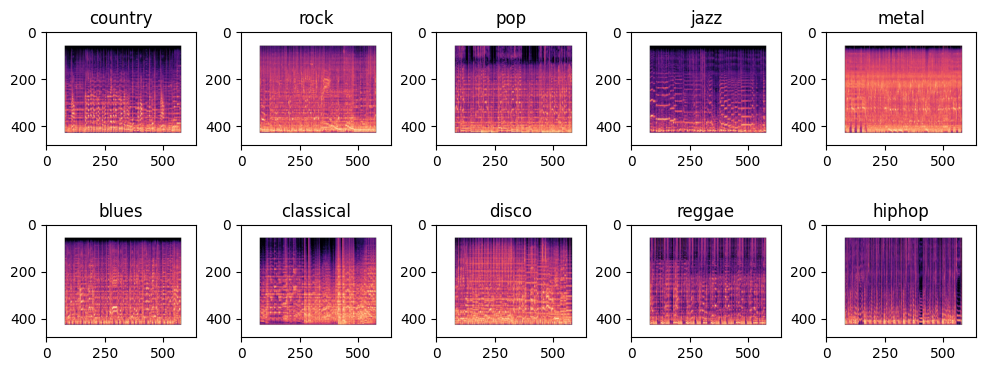

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Set the path to the folder containing the 10 subfolders with spectrogram images
base_folder = "/kaggle/working/Spectrograms_computed"

# Get a list of subfolders in the base folder
subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]

# Create a subplot with 5 rows and 2 columns
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 5, wspace=0.3, hspace=0.00000001)

# Iterate through the subfolders
for i, subfolder in enumerate(subfolders):
    # Get the list of images in the subfolder
    images = [f for f in os.listdir(subfolder) if f.endswith('.png') or f.endswith('.jpg')]
    
    # Check if there's at least one image in the subfolder
    if images:
        # Take the first image from the subfolder
        first_image_path = os.path.join(subfolder, images[0])

        # Read the image using OpenCV
        img = cv2.imread(first_image_path)

        # Display the image
        ax = plt.subplot(gs[i])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(os.path.basename(subfolder))

# Remove empty subplots
for i in range(len(subfolders), 10):
    fig.delaxes(plt.subplot(gs[i]))
    
plt.savefig("/kaggle/working/spectrograms.png", bbox_inches="tight")
# Show the plot
plt.show()

In [11]:
classes = [a for a in os.listdir('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original') if '.' not in a]
print(classes)

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [12]:
'Create X and Y for: train, valid, test'

img_size = 256
dataset=[]
for label in classes:
    path = os.path.join(parent_directory, label)
    class_num = classes.index(label)
    
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            dataset.append([resized_arr, class_num])
        except Exception as e:
            print(e)

dataset_toUse = np.array(dataset)
print(dataset_toUse.shape)

(999, 2)


/tmp/ipykernel_32/607387902.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset_toUse = np.array(dataset)


In [13]:
X = []
Y = []
for feature, label in dataset_toUse:
    X.append(feature)
    Y.append(label)

X = np.array(X) / 255.
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(999, 256, 256, 3)
(999,)


# **Transfer learning part** #

In [14]:
import tensorflow as tf
from tensorflow.keras import applications, layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
x_train, x_aux, y_train, y_aux = train_test_split(X,Y, test_size = 0.2, random_state = 42)
x_test, x_valid, y_test, y_valid = train_test_split(x_aux, y_aux, test_size = 0.5, random_state = 42)

# x_train.reshape(-1, img_size, img_size, 1)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(799, 256, 256, 3) (799,)
(100, 256, 256, 3) (100,)
(100, 256, 256, 3) (100,)


# **VGG 16**

In [16]:
# Load the model chose for transfer learning, excluding the top (classification) layer
base_model =  tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
  
    
x = base_model.output 
# Add your custom classification head
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.005))(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(10, activation='softmax')(x)  # 10 classes for music genres

# Create a new model with the custom input and classification head
model = models.Model(inputs=base_model.input, outputs=output)

# model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# callbacks = [EarlyStopping(monitor='val_loss', patience=7, verbose=1)]

# Fit the model
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=30, batch_size=32)

# Evaluate the model on the test set
results = model.evaluate(x_test, y_test)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/30
25/25 [==============================] - 16s 222ms/step - loss: 2.3712 - accuracy: 0.0876 - val_loss: 761.5756 - val_accuracy: 0.0800
Epoch 2/30
25/25 [==============================] - 2s 95ms/step - loss: 2.2031 - accuracy: 0.1952 - val_loss: 1213.7657 - val_accuracy: 0.2500
Epoch 3/30
25/25 [==============================] - 2s 95ms/step - loss: 2.1070 - accuracy: 0.2891 - val_loss: 1625.5231 - val_accuracy: 0.3200
Epoch 4/30
25/25 [==============================] - 2s 96ms/step - loss: 2.0105 - accuracy: 0.3492 - val_loss: 2171.1711 - val_accuracy: 0.2800
Epoch 5/30
25/25 [==============================] - 2s 94ms/step - loss: 1.9079 - accuracy: 0.3542 - val_loss: 2903.3413 - val_accuracy: 0.3300
Epoch 6/30
25/25 [==============================] - 2s 95ms/step - loss: 1.8289 - accuracy: 0.3917 - val_loss: 3634.2678 - val_accuracy: 0.4000
Epoch 7/30
25/25 [==============================] - 2s 95ms/step - los

# **MobileNetV2**

In [19]:
# Load the model chose for transfer learning, excluding the top (classification) layer
base_model =  tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
  
    
x = base_model.output 
# Add your custom classification head
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.005))(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(10, activation='softmax')(x)  # 10 classes for music genres

# Create a new model with the custom input and classification head
model = models.Model(inputs=base_model.input, outputs=output)

# model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# callbacks = [EarlyStopping(monitor='val_loss', patience=7, verbose=1)]

# Fit the model
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=30, batch_size=32)

# Evaluate the model on the test set
results = model.evaluate(x_test, y_test)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])



Epoch 1/30
25/25 [==============================] - 6s 120ms/step - loss: 1.9381 - accuracy: 0.3292 - val_loss: 1.4761 - val_accuracy: 0.5000
Epoch 2/30
25/25 [==============================] - 1s 44ms/step - loss: 1.3801 - accuracy: 0.5232 - val_loss: 1.2916 - val_accuracy: 0.5500
Epoch 3/30
25/25 [==============================] - 1s 43ms/step - loss: 1.1670 - accuracy: 0.5870 - val_loss: 1.1856 - val_accuracy: 0.5600
Epoch 4/30
25/25 [==============================] - 1s 44ms/step - loss: 1.0671 - accuracy: 0.6471 - val_loss: 1.1594 - val_accuracy: 0.5300
Epoch 5/30
25/25 [==============================] - 1s 43ms/step - loss: 0.9807 - accuracy: 0.6783 - val_loss: 1.1513 - val_accuracy: 0.6100
Epoch 6/30
25/25 [==============================] - 1s 43ms/step - loss: 0.9169 - accuracy: 0.6758 - val_loss: 1.0486 - val_accuracy: 0.6400
Epoch 7/30
25/25 [==============================] - 1s 44ms/step - loss: 0.8580 - accuracy: 0.7146 - val_loss: 1.0457 - val_accuracy: 0.6300
Epoch 8/30
2

# **InceptionV3**

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
    
base_model.layers[-1].trainable = True

# Define the custom classification head
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(10, activation='softmax')(x)  # 10 classes for music genres

# Create a new model with the custom input and classification head
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum = 0.7), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50, batch_size=8)

# Evaluate the model on the test set
results = model.evaluate(x_test, y_test)
# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/50
100/100 [==============================] - 11s 60ms/step - loss: 2.1072 - accuracy: 0.2428 - val_loss: 1.8496 - val_accuracy: 0.2900
Epoch 2/50
100/100 [==============================] - 3s 29ms/step - loss: 1.6854 - accuracy: 0.3867 - val_loss: 1.6280 - val_accuracy: 0.3800
Epoch 3/50
100/100 [==============================] - 3s 29ms/step - loss: 1.4595 - accuracy: 0.4881 - val_loss: 1.6584 - val_accuracy: 0.3400
Epoch 4/50
100/100 [==============================] - 3s 29ms/step - loss: 1.3860 - accuracy: 0.5131 - val_loss: 1.4705 - val_accuracy: 0.5200
Epoch 5/50
100/100 [==============================] - 3s 29ms/step - loss: 1.2419 - accuracy: 0.5369 - val_loss: 1.5562 - val_accuracy: 0.4800
Epoch 6/50
100/100 [==============================] - 3s 30ms/step - loss: 1.1982 - accuracy: 0.5707 - val_loss: 1.6438 - val_accuracy: 0.5400
Epoch 7/50
100/100 [==============================] - 3s 29ms/step - loss: 1

# **Xception**

In [21]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
    
base_model.layers[-1].trainable = True

# Define the custom classification head
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(10, activation='softmax')(x)  # 10 classes for music genres

# Create a new model with the custom input and classification head
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum = 0.7), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50, batch_size=8)

# Evaluate the model on the test set
results = model.evaluate(x_test, y_test)
# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


83683744/83683744 [==============================] - 4s 0us/step
Epoch 1/50
100/100 [==============================] - 8s 49ms/step - loss: 2.0963 - accuracy: 0.2503 - val_loss: 1.8244 - val_accuracy: 0.3300
Epoch 2/50
100/100 [==============================] - 3s 33ms/step - loss: 1.6698 - accuracy: 0.4218 - val_loss: 1.6008 - val_accuracy: 0.4100
Epoch 3/50
100/100 [==============================] - 3s 33ms/step - loss: 1.4661 - accuracy: 0.4844 - val_loss: 1.5642 - val_accuracy: 0.4300
Epoch 4/50
100/100 [==============================] - 3s 33ms/step - loss: 1.3762 - accuracy: 0.5156 - val_loss: 1.3667 - val_accuracy: 0.4800
Epoch 5/50
100/100 [==============================] - 3s 33ms/step - loss: 1.2973 - accuracy: 0.5432 - val_loss: 1.5246 - val_accuracy: 0.3600
Epoch 6/50
100/100 [==============================] - 3s 33ms/step - loss: 1.1881 - accuracy: 0.5932 - val_loss: 1.3003 - val_accuracy: 0.5100
Epoch 7/50
100/100 [==============================] - 3s 33ms/step - loss: 1.